Loading train/test splits...
X_train shape: (3392, 15)
X_test shape: (848, 15)


=== Running with CV=3 ===

--- Seed 0 ---

--- Seed 1 ---

--- Seed 2 ---

--- Seed 3 ---

--- Seed 4 ---

--- Seed 5 ---

--- Seed 6 ---

--- Seed 7 ---

--- Seed 8 ---

--- Seed 9 ---

--- Seed 10 ---

--- Seed 11 ---

--- Seed 12 ---

--- Seed 13 ---

--- Seed 14 ---

--- Seed 15 ---

--- Seed 16 ---

--- Seed 17 ---

--- Seed 18 ---

--- Seed 19 ---

=== Summary for CV=3 ===
           seed          C  best_threshold    best_f1
count  20.00000  20.000000       20.000000  20.000000
mean    9.50000   0.455500        0.516162   0.382689
std     5.91608   0.864307        0.024502   0.019684
min     0.00000   0.010000        0.484848   0.345070
25%     4.75000   0.010000        0.502525   0.372159
50%     9.50000   0.100000        0.510101   0.388215
75%    14.25000   0.325000        0.537879   0.393685
max    19.00000   3.500000        0.565657   0.415205

=== Running with CV=5 ===

--- Seed 0 ---

--- See

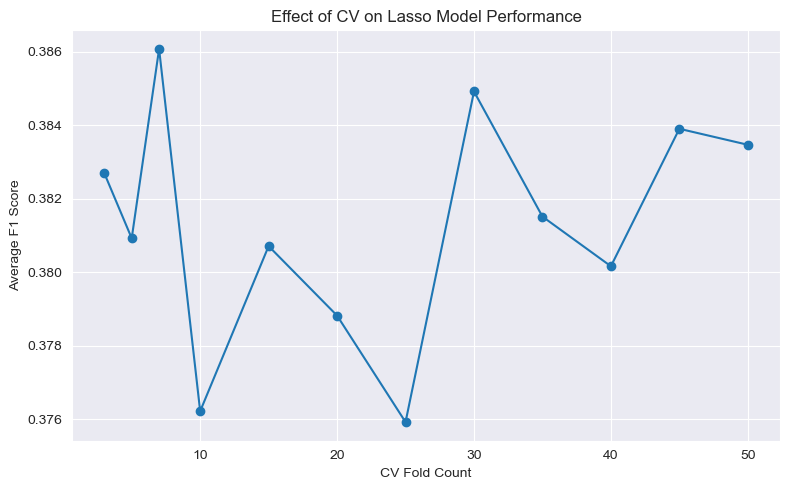

All results saved in ../results/


In [19]:
# --- 03_lasso_regression_gridsearch_subsampling_cvloop.ipynb ---

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.utils import resample
import shap

# 1. Load preprocessed data
print("Loading train/test splits...")
X_train = np.load("../data/splits/X_train.npy")
y_train = np.load("../data/splits/y_train.npy")
X_test = np.load("../data/splits/X_test.npy")
y_test = np.load("../data/splits/y_test.npy")

# Convert numpy arrays back to pandas DataFrame
X_train_columns = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
X_train = pd.DataFrame(X_train, columns=X_train_columns)
X_test = pd.DataFrame(X_test, columns=X_train_columns)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}\n")

# 2. Set up GridSearchCV for Lasso Logistic Regression
param_grid = {
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5,
          0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5,
          4.0, 4.5, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0,
          25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0,
          70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, 150.0,
          200.0, 250.0, 300.0, 400.0, 500.0],
    'penalty': ['l1'],
    'solver': ['liblinear'],
}

cv_values = [3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50]
overall_cv_results = {}

for cv in cv_values:
    print(f"\n=== Running with CV={cv} ===")
    results_list = []
    all_best_f1s = []
    all_models = []
    all_thresholds = []
    all_probs = []

    for seed in range(20):
        print(f"\n--- Seed {seed} ---")

        # Down-sample majority class
        X_minority = X_train[y_train == 1]
        y_minority = y_train[y_train == 1]

        X_majority = X_train[y_train == 0]
        y_majority = y_train[y_train == 0]

        X_majority_downsampled, y_majority_downsampled = resample(
            X_majority, y_majority,
            replace=False,
            n_samples=len(X_minority),
            random_state=seed
        )

        X_resampled = pd.concat([
            pd.DataFrame(X_majority_downsampled, columns=X_train.columns),
            pd.DataFrame(X_minority, columns=X_train.columns)
        ], ignore_index=True)

        y_resampled = np.hstack((y_majority_downsampled, y_minority))

        grid_search = GridSearchCV(
            LogisticRegression(max_iter=1000, random_state=seed),
            param_grid,
            scoring='f1',
            cv=cv,
            verbose=0,
            n_jobs=-1
        )

        grid_search.fit(X_resampled, y_resampled)
        best_model = grid_search.best_estimator_

        y_probs = best_model.predict_proba(X_test)[:, 1]
        thresholds = np.linspace(0, 1, 100)
        f1_scores = [f1_score(y_test, (y_probs >= t).astype(int)) for t in thresholds]
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]
        best_f1 = f1_scores[best_idx]

        results_list.append({
            'seed': seed,
            'C': grid_search.best_params_['C'],
            'best_threshold': best_threshold,
            'best_f1': best_f1
        })

        all_best_f1s.append(best_f1)
        all_models.append(best_model)
        all_thresholds.append(best_threshold)
        all_probs.append(y_probs)

    # Store all results for current CV value
    results_df = pd.DataFrame(results_list)
    overall_cv_results[cv] = results_df

    print(f"\n=== Summary for CV={cv} ===")
    print(results_df.describe())

# === Plot average F1 score vs. CV value ===
avg_f1s = {cv: df['best_f1'].mean() for cv, df in overall_cv_results.items()}

plt.figure(figsize=(8, 5))
plt.plot(list(avg_f1s.keys()), list(avg_f1s.values()), marker='o')
plt.xlabel("CV Fold Count")
plt.ylabel("Average F1 Score")
plt.title("Effect of CV on Lasso Model Performance")
plt.grid(True)
plt.tight_layout()
plt.show()

# Save all results
os.makedirs("../results", exist_ok=True)
for cv, df in overall_cv_results.items():
    df.to_csv(f"../results/lasso_cv_{cv}_subsampling_results.csv", index=False)

print("All results saved in ../results/")
